In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from random import randint, random

# Prepare Data

In [20]:
import json, gzip
TRAIN_DEV_SPLIT = 50000

# LOAD DATA
train = []
test = []

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    for sample in [json.loads(line) for line in file]:
        img = np.array(sample['image']).reshape((28,28))
        img_pts = []
        for x in range(28):
            for y in range(28):
                z = img[x][y]
                if z > 0:
                    img_pts.append((x,y,z))
        label = sample['label']
        
        dataset = train if sample['split'] == 'train' else test
        dataset.append((img_pts, label))

dev = train[TRAIN_DEV_SPLIT:]
train = train[:TRAIN_DEV_SPLIT]

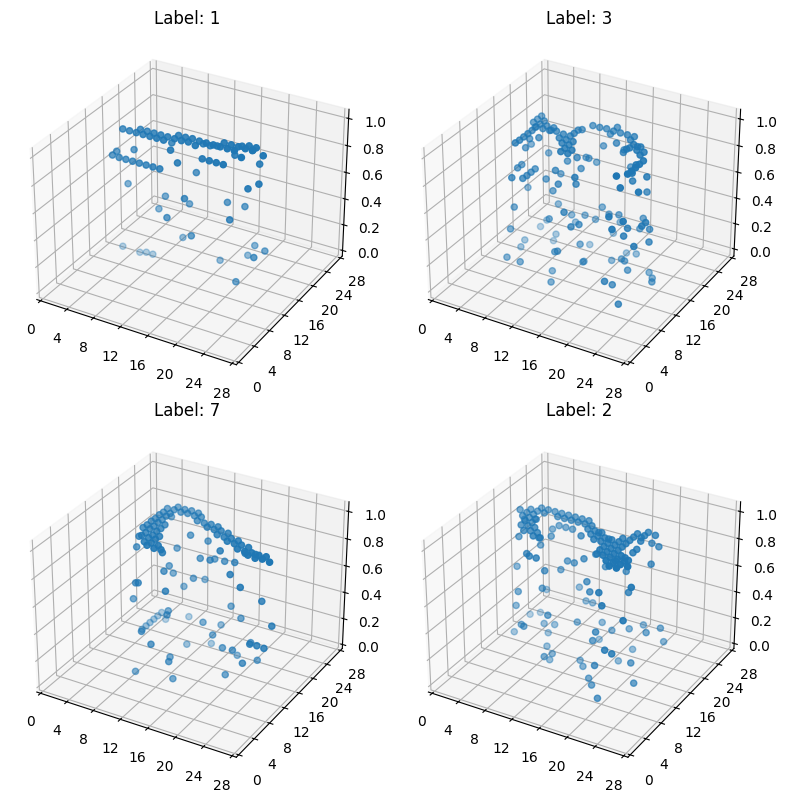

In [97]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
    pts = train[i][0]
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(f'Label: {train[i][1]}')
    ax.scatter([p[0] for p in pts], [p[1] for p in pts], [p[2] for p in pts])
    ax.set_xticks(np.arange(0,29,4))
    ax.set_yticks(np.arange(0,29,4))
plt.tight_layout()
plt.show()

# Create Clusters

In [22]:
def distance(p, q):
    return (p[0] - q[0])**2 + (p[1] - q[1])**2 + 1000*(p[2] - q[2])**2

In [23]:
def lloyd(image: list[tuple[int, int, float]], K: int):
    # initialize cluster centers
    centers = [ (randint(0,27),randint(0,27),random()) for k in range(K) ]
    # repeat until convergence
    while True:
        # assign every point to nearest clutser
        S = [[] for k in range(K)]
        for pt in image:
            if pt[2] == 0:
                continue
            nearest_K = np.argmin([ distance(pt, centers[k]) for k in range(K) ])
            S[nearest_K].append(pt)
        # get mean for each cluster
        prev_centers = centers.copy()
        for k in range(K):
            k_size = len(S[k])
            if k_size == 0:
                continue
            k_sum_x = sum([ pt[0] for pt in S[k] ])
            k_sum_y = sum([ pt[1] for pt in S[k] ])
            k_sum_z = sum([ pt[2] for pt in S[k] ])
            centers[k] = [ k_sum_x/k_size, k_sum_y/k_size, k_sum_z/k_size ]
        # check convergence
        if centers == prev_centers:
            return S, centers

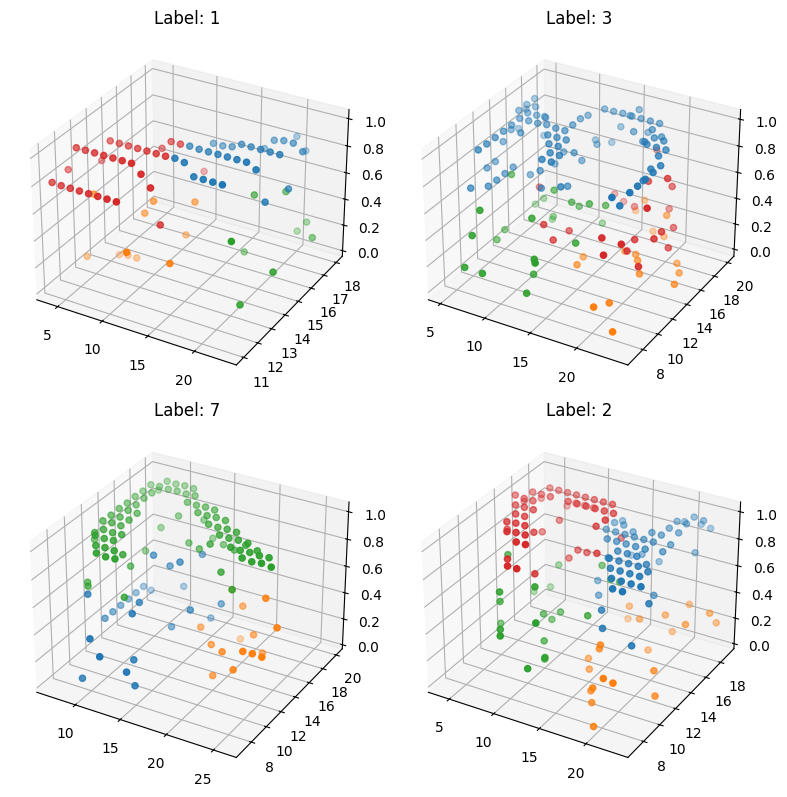

In [24]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
    S, centers = lloyd(train[i][0], 4)
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(f'Label: {train[i][1]}')
    for pts in S:
        ax.scatter([p[0] for p in pts], [p[1] for p in pts], [p[2] for p in pts])
    # ax.scatter([k[0] for k in centers], [k[1] for k in centers], [k[2] for k in centers], c='red', marker='*')
plt.tight_layout()
plt.show()

# Classification

In [78]:
class ClusterClassifier(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.layers = nn.Sequential(
            # takes in K three dimensional points [K, 3]
            nn.Linear(3, 1),    # [K, 3] -> [K, 1]
            nn.Flatten(0),      # [K, 1] -> [K]
            nn.ReLU(),
            nn.Linear(K, 10),   # [K] -> [10]
            nn.ReLU()
        )
        self.cuda()
    
    def forward(self, x):
        return self.layers(x)

In [84]:
model = ClusterClassifier(5)

def train_cc():
    criterion = nn.MultiMarginLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for img, label in train:
        S, centers = lloyd(img, 5)
        x = torch.tensor(centers, dtype=torch.float32).cuda()
        y = torch.tensor([label], dtype=torch.long).cuda()
        
        # forward pass
        logits = model.forward(x)

        # calculate gradients
        loss = criterion(logits, y)
        loss.backward()

        # backward pass
        optimizer.step()
        optimizer.zero_grad()

train_cc()

In [89]:
def eval_cc():
    score = 0

    for img, label in dev:
        S, centers = lloyd(img, 5)
        x = torch.tensor(centers, dtype=torch.float32).cuda()
        
        # forward pass
        with torch.no_grad():
            logits = model.forward(x)
            label_pred = logits.argmax().item()

        # calculate score
        if label_pred == label:
            score += 1
    
    print(f'Accuracy: {100*(score/len(dev)):.2f}%')
eval_cc()

Accuracy: 15.65%
